core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.7.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No 

   Driver  PredictedRaceTime (s)
0     NOR              89.514648
1     VER              89.586823
2     PIA              89.586823
3     SAI              89.686806
4     RUS              89.994560
5     LEC              90.066734
6     HAM              90.217407
7     HUL              90.763794
8     ALO              90.769188
9     ALB              90.812805
10    STR              90.981590
11    GAS              91.070442

🏆 Predicted in the Top 3 🏆
🥇 P1: NOR
🥈 P2: VER
🥉 P3: PIA
Model Error (MAE): 0.91 seconds


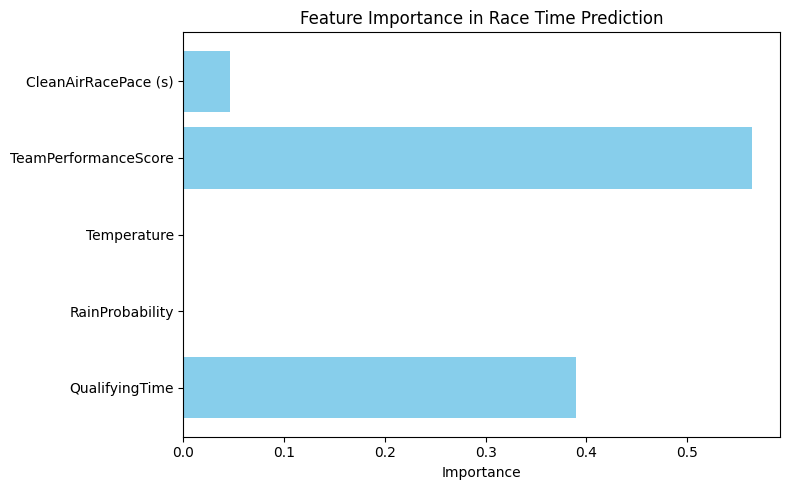

In [1]:
import fastf1 # type: ignore
import pandas as pd
import numpy as np
import requests
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor # type: ignore

if not os.path.exists("f1_cache"):
    os.makedirs("f1_cache")

fastf1.Cache.enable_cache("f1_cache")

# load the 2024 Qatar session data
session_2024 = fastf1.get_session(2024, 24, "R")
session_2024.load()
laps_2024 = session_2024.laps[["Driver", "LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]].copy()
laps_2024.dropna(inplace=True)

# convert lap and sector times to seconds
for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
    laps_2024[f"{col} (s)"] = laps_2024[col].dt.total_seconds()

# aggregate sector times by driver
sector_times_2024 = laps_2024.groupby("Driver").agg({
    "Sector1Time (s)": "mean",
    "Sector2Time (s)": "mean",
    "Sector3Time (s)": "mean"
}).reset_index()

sector_times_2024["TotalSectorTime (s)"] = (
    sector_times_2024["Sector1Time (s)"] +
    sector_times_2024["Sector2Time (s)"] +
    sector_times_2024["Sector3Time (s)"]
)

# clean air race pace from racepace.py
clean_air_race_pace = {
    "VER": 93.191067, "HAM": 94.020622, "LEC": 93.418667, "NOR": 93.428600, "ALO": 94.784333,
    "PIA": 93.232111, "RUS": 93.833378, "SAI": 94.497444, "STR": 95.318250, "HUL": 95.345455,
    "OCO": 95.682128
}

# quali data from Abu Dhabi GP
qualifying_2025 = pd.DataFrame({
    "Driver": ["RUS", "VER", "PIA", "NOR", "HAM", "LEC", "ALO", "HUL", "ALB", "SAI", "STR", "OCO", "GAS"],
    "QualifyingTime (s)": [
        82.645,  # RUS
        82.207,  # VER
        82.437,  # PIA
        82.408,  # NOR
        83.394,  # HAM
        82.730,  # LEC
        82.902,  # ALO
        83.450,  # HUL
        83.416,  # ALB
        83.042,  # SAI
        83.097,  # STR
        82.913,  # OCO
        83.468   # GAS
    ]
})


qualifying_2025["CleanAirRacePace (s)"] = qualifying_2025["Driver"].map(clean_air_race_pace)
qualifying_2025["WetPerformanceFactor"] = 1.1 # Default wet factor to prevent KeyError
API_KEY = ""
lat, lon = 24.4672, 54.6031  
weather_url = f"http://api.openweathermap.org/data/2.5/forecast?lat={lat}&lon={lon}&appid={API_KEY}&units=metric"
forecast_data = None
if API_KEY:
    try:
        response = requests.get(weather_url)
        if response.status_code == 200:
            weather_data = response.json()
            forecast_time = "2025-12-07 13:00:00"
            forecast_data = next((f for f in weather_data.get("list", []) if f["dt_txt"] == forecast_time), None)
    except Exception:
        pass


rain_probability = forecast_data["pop"] if forecast_data else 0
temperature = forecast_data["main"]["temp"] if forecast_data else 20

# adjust qualifying time based on weather conditions
if rain_probability >= 0.75:
    qualifying_2025["QualifyingTime"] = qualifying_2025["QualifyingTime (s)"] * qualifying_2025["WetPerformanceFactor"]
else:
    qualifying_2025["QualifyingTime"] = qualifying_2025["QualifyingTime (s)"]

# add constructor's data
team_points = {
    "McLaren": 800, "Mercedes": 459, "Red Bull": 426, "Williams": 137, "Ferrari": 382,
    "Haas": 73, "Aston Martin": 80, "Kick Sauber": 68, "Racing Bulls": 92, "Alpine": 22
}

max_points = max(team_points.values())
team_performance_score = {team: points / max_points for team, points in team_points.items()}

driver_to_team = {
    "VER": "Red Bull", "NOR": "McLaren", "PIA": "McLaren", "LEC": "Ferrari", "RUS": "Mercedes",
    "HAM": "Ferrari", "GAS": "Alpine", "ALO": "Aston Martin", "TSU": "Racing Bulls",
    "SAI": "Williams", "HUL": "Kick Sauber", "OCO": "Alpine", "STR": "Aston Martin"
}

qualifying_2025["Team"] = qualifying_2025["Driver"].map(driver_to_team)
qualifying_2025["TeamPerformanceScore"] = qualifying_2025["Team"].map(team_performance_score)

# merge qualifying and sector times data
merged_data = qualifying_2025.merge(sector_times_2024[["Driver", "TotalSectorTime (s)"]], on="Driver", how="left")
merged_data["RainProbability"] = rain_probability
merged_data["Temperature"] = temperature
merged_data["QualifyingTime"] = merged_data["QualifyingTime"]


valid_drivers = merged_data["Driver"].isin(laps_2024["Driver"].unique())
merged_data = merged_data[valid_drivers]

# define features (X) and target (y)
X = merged_data[[
    "QualifyingTime", "RainProbability", "Temperature", "TeamPerformanceScore", 
    "CleanAirRacePace (s)"
]]
y = laps_2024.groupby("Driver")["LapTime (s)"].mean().reindex(merged_data["Driver"])

# impute missing values for features
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.1, random_state=39)

# train XGBoost model
model = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=39,  monotone_constraints='(1, 0, 0, -1, -1)')
model.fit(X_train, y_train)
merged_data["PredictedRaceTime (s)"] = model.predict(X_imputed)

# sort the results to find the predicted winner
final_results = merged_data.sort_values(by=["PredictedRaceTime (s)", "QualifyingTime"]).reset_index(drop=True)
print(final_results[["Driver", "PredictedRaceTime (s)"]])

# sort results and get top 3
podium = final_results.loc[:7, ["Driver", "PredictedRaceTime (s)"]]
print("\n🏆 Predicted in the Top 3 🏆")
print(f"🥇 P1: {podium.iloc[0]['Driver']}")
print(f"🥈 P2: {podium.iloc[1]['Driver']}")
print(f"🥉 P3: {podium.iloc[2]['Driver']}")
y_pred = model.predict(X_test)
print(f"Model Error (MAE): {mean_absolute_error(y_test, y_pred):.2f} seconds")

# Plot feature importances
feature_importance = model.feature_importances_
features = X.columns 

plt.figure(figsize=(8,5))
plt.barh(features, feature_importance, color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importance in Race Time Prediction")
plt.tight_layout()
plt.show()
